Finding the largest area rectangle within a masked array

In [1]:
import numpy as np
from scipy import ndimage as ndi

In [4]:
test_array = np.zeros([6,6])
test_array[0,:3] = 1
test_array[3:,0] = 1
test_array[-1,3:] = 1
test_array[:3,-1] = 1
test_array

array([[1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1.]])

max area should be 16, with the slice [1:5, 1:5]

In [20]:
structure = np.zeros([3,3])
structure[1] = 1

In [28]:
row_labels = ndi.label(np.logical_not(test_array), structure)[0]
col_labels = ndi.label(np.logical_not(test_array), structure.T)[0]

row_label_counts = np.bincount(row_labels.ravel())
col_label_counts = np.bincount(col_labels.ravel())

In [79]:
row_ids = np.zeros(test_array.shape, dtype=int)
row_ids.ravel()[np.argsort(row_labels.ravel(), kind='mergesort')] = np.arange(row_ids.size)
row_ids -= np.cumsum(np.concatenate([[0],row_label_counts[:-1]]))[row_labels]

In [80]:
col_ids = np.zeros(test_array.shape, dtype=int)
col_ids.ravel()[np.argsort(col_labels.ravel(), kind='mergesort')] = np.arange(col_ids.size)
col_ids -= np.cumsum(np.concatenate([[0],col_label_counts[:-1]]))[col_labels]

In [96]:
max_area = 0
max_slice = (slice(None), slice(None))

In [113]:
corners = np.stack(np.where(test_array==0),-1)

In [114]:
x, y = corners[0]

In [115]:
x, y

(0, 3)

In [116]:
row_labels[x,y], col_labels[x,y]

(1, 1)

In [117]:
row_ids[x,y], col_ids[x,y]

(0, 0)

In [125]:
row_label_counts[row_labels[x,y]], col_label_counts[col_labels[x,y]]
max_w, max_h = row_label_counts[row_labels[x,y]] - row_ids[x,y], col_label_counts[col_labels[x,y]] - col_ids[x,y]
max_w, max_h

(2, 5)

In [130]:
for i in range(y, y+max_w):
    w = i-y+1
    h = col_label_counts[col_labels[x,i]] - col_ids[x,i]
    max_h = max_h if max_h >= h else h
    area = w * max_h
    if area > max_area:
        max_area = area
        max_slice = (slice(x, x+max_h), slice(y, i))
        print(i, max_area, max_slice)
    elif max_w*max_h <= max_area:
        break
    

In [91]:
max_h * max_w

10

In [92]:
max_h * max_w > max_area

True

In [99]:
x + max_w, y + max_h

(5, 5)

In [105]:
row_labels[5-1,3]

5

In [104]:
col_labels

array([[0, 0, 0, 1, 2, 0],
       [3, 4, 5, 1, 2, 0],
       [3, 4, 5, 1, 2, 0],
       [0, 4, 5, 1, 2, 6],
       [0, 4, 5, 1, 2, 6],
       [0, 4, 5, 0, 0, 0]], dtype=int32)

In [106]:
row_labels

array([[0, 0, 0, 1, 1, 0],
       [2, 2, 2, 2, 2, 0],
       [3, 3, 3, 3, 3, 0],
       [0, 4, 4, 4, 4, 4],
       [0, 5, 5, 5, 5, 5],
       [0, 6, 6, 0, 0, 0]], dtype=int32)

In [109]:
row_label_counts[5] - row_ids[5-1,3]

True

In [112]:
x,y,max_h,max_w

(0, 3, 2, 5)

In [174]:
from numba import njit, jit

In [177]:
def get_max_rect(array):
    structure = np.full((3,3), 0)
    structure[1] = 1
    
    row_labels = ndi.label(np.logical_not(array), structure)[0]
    col_labels = ndi.label(np.logical_not(array), structure.T)[0]

    row_label_counts = np.bincount(row_labels.ravel())
    col_label_counts = np.bincount(col_labels.ravel())
    
    row_ids = np.zeros(array.shape, dtype=int)
    row_ids.ravel()[np.argsort(row_labels.ravel(), kind='mergesort')] = np.arange(row_ids.size)
    row_ids -= np.cumsum(np.concatenate([[0],row_label_counts[:-1]]))[row_labels]
    
    col_ids = np.zeros(array.shape, dtype=int)
    col_ids.ravel()[np.argsort(col_labels.ravel(), kind='mergesort')] = np.arange(col_ids.size)
    col_ids -= np.cumsum(np.concatenate([[0],col_label_counts[:-1]]))[col_labels]
    
    max_area = 0
    max_slice = (slice(None), slice(None))

    for x, y in np.stack(np.where(array==0),-1):
        max_w, max_h = row_label_counts[row_labels[x,y]] - row_ids[x,y], col_label_counts[col_labels[x,y]] - col_ids[x,y]
        if max_w*max_h >= max_area:
            for i in range(y, y+max_w):
                w = i-y+1
                h = col_label_counts[col_labels[x,i]] - col_ids[x,i]
                max_h = max_h if max_h <= h else h
                area = w * max_h
                if area > max_area:
                    max_area = area
                    max_slice = (slice(x, x+max_h), slice(y, i+1))
#                     print(i, h, max_h, max_area, max_slice)
                elif max_w*max_h <= max_area:
                    break
    
    return max_area, max_slice

    

In [178]:
area, slices = get_max_rect(test_array)

In [179]:
test_array[slices]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [187]:
new_test = np.random.rand(200,200)>0.9

In [188]:
_, test_slice = get_max_rect(new_test)

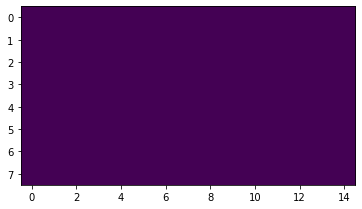

In [189]:
from matplotlib import pyplot as plt
plt.imshow(new_test[test_slice])

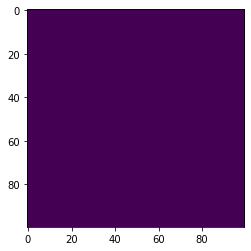

In [186]:
new_test[:100,:100] = 0
_, test_slice = get_max_rect(new_test)
plt.imshow(new_test[test_slice])